<a href="https://colab.research.google.com/github/saimayasmeen4/-DL-Assignment-4/blob/main/real_and_fake_news_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from nltk.classify.scikitlearn import SklearnClassifier
import pandas as pd
import gensim
import nltk
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.tree import DecisionTreeClassifier

import sklearn
nltk.download('punkt')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn import svm
svc = svm.SVC()
import seaborn as sns 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english') 
import re
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import matplotlib.pyplot as plt
 
from tabulate import tabulate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier
from collections import defaultdict
import gensim
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import re
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.feature_extraction import DictVectorizer  
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
 
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Utils**

In [ ]:
class GloveVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([self.nlp(text).vector for text in X])
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        # self.dim = len(word2vec.itervalues().next())
        self.dim = len(next(iter(self.word2vec.items()))[1])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] or [np.zeros(self.dim)], axis=0) for words in X])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        # self.dim = len(word2vec.itervalues().next())
        self.dim = len(next(iter((word2vec.items()))))

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] * self.word2weight[w]
                     for w in words if w in self.word2vec] or
                    [np.zeros(self.dim)], axis=0)
            for words in X
        ])


class MySentences(object):
    def __init__(self, docs):
        self.corpus = docs
    def __iter__(self):
        for doc in self.corpus:
            doc_sentences = sent_tokenize(doc)
            for sent in doc_sentences:
                yield simple_preprocess(sent) # yields a tokenized 

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str


# **Data Preparation**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Fiverr/Fake_News_Detection/news.csv')
data.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


# **Preprocessing**

### **Lowercase**

In [ ]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'].head()

0    daniel greenfield, a shillman journalism fello...
1    google pinterest digg linkedin reddit stumbleu...
2    u.s. secretary of state john f. kerry said mon...
3    — kaydee king (@kaydeeking) november 9, 2016 t...
4    it's primary day in new york and front-runners...
Name: text, dtype: object

### **Remove Punctuation**

In [ ]:
# Remove punctuation
data['text'] = data['text'].apply(punctuation_removal)
data['text'].head()

0    daniel greenfield a shillman journalism fellow...
1    google pinterest digg linkedin reddit stumbleu...
2    us secretary of state john f kerry said monday...
3    — kaydee king kaydeeking november 9 2016 the l...
4    its primary day in new york and frontrunners h...
Name: text, dtype: object

### **Stopword Removal**

In [ ]:
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
data['text'].head()

0    daniel greenfield shillman journalism fellow f...
1    google pinterest digg linkedin reddit stumbleu...
2    us secretary state john f kerry said monday st...
3    — kaydee king kaydeeking november 9 2016 lesso...
4    primary day new york frontrunners hillary clin...
Name: text, dtype: object

### **Stemming**

In [ ]:
import pandas as pd
from nltk.stem.snowball import SnowballStemmer

# Use English stemmer.
stemmer = SnowballStemmer("english")

In [ ]:
# data['text']=data['text'].str.split()
data['text'] = data['text'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

### Lemmanization

In [ ]:
import nltk
nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

 
data['text']= data['text'].text.apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Labeling**

In [ ]:
for i in range(len(data.text)):
  if data['label'][i]=='FAKE':
    # print(data['label'][i],'fake')
    data['label'][i]=0
  if data['label'][i]=='REAL':
    # print(data['label'][i],'real')
    data['label'][i]=1

data['label']=pd.to_numeric(data["label"])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# **Feature Extraction**

## **Glove**

In [ ]:
# !python -m spacy download en_core_web_lg
import re
import numpy as np
import pandas as pd
import spacy
import string
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
 
column_preprocessor = ColumnTransformer(
    [
        ('text_glove', GloveVectorTransformer(nlp), 'text'),
    ],
    remainder='drop',
    n_jobs=1
)

pipeline = Pipeline([
    ('column_preprocessor', column_preprocessor),
    # ('svm', svm.SVC(kernel='rbf', C=1.2, gamma=0.2))
    ('RF', RandomForestClassifier())
])

print("start pipeline fit")
pipeline.fit(data, data.label)

start pipeline fit


Pipeline(steps=[('column_preprocessor',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('text_glove',
                                                  GloveVectorTransformer(nlp=<spacy.lang.en.English object at 0x7f9951895d10>),
                                                  'text')])),
                ('RF', RandomForestClassifier())])

## **Bag of word**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
print( vectorizer.fit_transform(data.text).todense() )
print( vectorizer.vocabulary_ )

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
{'daniel': 20732, 'greenfield': 33276, 'shillman': 68155, 'journalism': 41236, 'fellow': 28955, 'freedom': 30820, 'center': 15322, 'new': 51441, 'york': 83157, 'writer': 82619, 'focusing': 30102, 'radical': 61129, 'islam': 40147, 'final': 29349, 'stretch': 71984, 'election': 25576, 'hillary': 35758, 'rodham': 64521, 'clinton': 16784, 'gone': 32750, 'war': 80685, 'fbi': 28747, 'word': 82355, 'unprecedented': 78508, 'thrown': 75140, 'around': 8386, 'often': 53433, 'ought': 54388, 'retired': 63691, 'it': 40273, 'still': 71614, 'nominee': 51975, 'major': 46011, 'political': 57953, 'party': 55637, 'go': 32571, 'that': 74564, 'exactly': 27388, 'people': 56226, 'done': 24013, 'coma': 17546, 'patients': 55810, 'waking': 80545, 'watching': 80876, 'hour': 36557, 'cnn': 17060, 'hospital': 36489, 'beds': 10667, 'would': 82509, 'assume': 8813, 'director': 22978, 'james': 40553, 'c

## **Word2vec**

In [ ]:
import numpy as np
with open("/content/drive/MyDrive/Fiverr/Fake_News_Detection/fake-news_dataset3/data/glove.6B.300d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

sentences = MySentences(data['text'].tolist())
model = gensim.models.Word2Vec(sentences, min_count=5, workers=8, size=300, sg=1)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
next(iter(w2v.items()))

('trump',
 array([ 0.10521929,  0.02181264, -0.01535711, -0.34216946, -0.3722495 ,
         0.11993019, -0.19036922, -0.08276631,  0.01921014,  0.53753483,
         0.11371234, -0.34209964, -0.3072576 ,  0.1018589 , -0.25536513,
         0.03970803,  0.23420632,  0.19614957, -0.02749075,  0.02523361,
        -0.31387135,  0.20144154, -0.43910766, -0.04772051,  0.33556712,
         0.31079346, -0.18383111, -0.02179061, -0.03839526,  0.07343614,
         0.12290447, -0.25676256, -0.16509698,  0.18775073, -0.3069214 ,
         0.01959372, -0.14708921,  0.01703986, -0.22628142, -0.09713917,
        -0.5143716 , -0.26522666,  0.36709976, -0.02964701, -0.09733603,
         0.13742562,  0.2750885 ,  0.2605854 , -0.24907434,  0.18548864,
         0.11291573, -0.16109566, -0.30649006, -0.33794788, -0.11635424,
        -0.09471328, -0.15700267,  0.11082609, -0.29170164, -0.27704114,
         0.25195268,  0.24549815, -0.05212378,  0.50498235,  0.3194835 ,
        -0.06085038, -0.21178491,  0.1050

In [ ]:
from itertools import islice
list(islice(model.wv.vocab.items(), 5))

[('daniel', <gensim.models.keyedvectors.Vocab at 0x7f82ac29b410>),
 ('greenfield', <gensim.models.keyedvectors.Vocab at 0x7f82ac2b0590>),
 ('journalism', <gensim.models.keyedvectors.Vocab at 0x7f82ac212610>),
 ('fellow', <gensim.models.keyedvectors.Vocab at 0x7f82ac212710>),
 ('freedom', <gensim.models.keyedvectors.Vocab at 0x7f82ac212b10>)]

## **TF-IDF**

In [ ]:

vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(data.text)
vectorizer.get_feature_names_out()
# tf_idf_df=pd.DataFrame(tf_idf)
# tf_idf_df

array(['00', '000', '0000', ..., 'هذا', 'والمرضى', 'ยงade'], dtype=object)

# **FeatureSelection Methods**

## **Chi-square statistic (CHI)**

In [ ]:
# Two features with highest chi-squared statistics are selected
chi2_features = SelectKBest(chi2, k = 100)
X_kbest_features = chi2_features.fit_transform(tf_idf, data.label)
print(X_kbest_features)
# Reduced features
print('Original feature number:', tf_idf.shape[1])
print('Reduced feature number:', X_kbest_features.shape[1])

  (0, 20)	0.016091107240815684
  (0, 8)	0.013307088373838576
  (0, 65)	0.023461954577427925
  (0, 7)	0.06697185866684176
  (0, 98)	0.026490747940941778
  (0, 76)	0.02247740188344138
  (0, 3)	0.018177264892573982
  (0, 82)	0.017579142799179517
  (0, 71)	0.028016160236521263
  (0, 38)	0.02446882884237108
  (0, 23)	0.044349736271324144
  (0, 93)	0.022367677076539416
  (0, 53)	0.035510444664499395
  (0, 13)	0.25546778363452743
  (0, 59)	0.012943698096311691
  (0, 52)	0.031695192867915514
  (0, 27)	0.5659270229184185
  (0, 37)	0.20298803521793476
  (1, 83)	0.044506506849657276
  (1, 15)	0.035628941275057974
  (1, 22)	0.027889908912668536
  (1, 0)	0.07354245502242651
  (1, 70)	0.02538890403386206
  (1, 64)	0.08559308181802334
  (1, 7)	0.02401346648389624
  :	:
  (6334, 6)	0.48239437010203057
  (6334, 30)	0.024099693588531527
  (6334, 36)	0.23755908027159175
  (6334, 45)	0.06119285606670321
  (6334, 33)	0.05139459850113924
  (6334, 57)	0.026291623202434715
  (6334, 61)	0.06090987033811207
  (

## **Mutual information (MI)/ Information gain (IG)**

In [ ]:
import sklearn
mutual_info_classif(tf_idf, data.label,  discrete_features='auto', n_neighbors=3, copy=True, random_state=None)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.

array([0.00098657, 0.00032888, 0.00032888, ..., 0.0001096 , 0.0001096 ,
       0.0001096 ])

## **Word Frequency**

In [ ]:
# Python3 code to find frequency of each word
# function for calculating the frequency
def freq(str):
  
    # break the string into list of words
    str_list = str.split()
  
    # gives set of unique words
    unique_words = set(str_list)
      
    for words in unique_words :
        print('Frequency of ', words , 'is :', str_list.count(words))
   

##**principal component analysis (PCA)**

In [ ]:
from sklearn.decomposition import PCA
pca = PCA( )
# pca.fit(tf_idf)

# **TECHNIQUES**

First three feature selection(**document frequency (DF)**, **information gain (IG)**, **chi-square statistic (CHI)**)  and first five feature extraction technique (**Bag-of-words**, **Tf**, **Tf-idf**,** Word2Vec**, **Glove**) with classifier and ensemblers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.label, test_size=0.1, random_state=44)
X_test=X_train
y_test=y_train

## **RF**

### **GloVE + Random Fores**

In [ ]:
 
column_preprocessor = ColumnTransformer(
    [
        ('text_glove', GloveVectorTransformer(nlp), 'text'),
    ],
    remainder='drop',
    n_jobs=1
)

pipeline = Pipeline([
    ('column_preprocessor', column_preprocessor),
     
    ('RF', RandomForestClassifier())
])

print("start pipeline fit")
 
pipeline.fit( X_train, y_train )
predictions0= pipeline.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions0))
print(classification_report(y_test,  predictions0))

start pipeline fit
Accuracy:  0.9784248377477636
              precision    recall  f1-score   support

        FAKE       0.96      1.00      0.98      2857
        REAL       1.00      0.96      0.98      2844

    accuracy                           0.98      5701
   macro avg       0.98      0.98      0.98      5701
weighted avg       0.98      0.98      0.98      5701



### **Word2vec + Random Forest**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
p1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('RandomForest', RandomForestClassifier())])
p1.fit( X_train, y_train )
predictions1= p1.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions1))
print(classification_report(y_test,  predictions1))

Accuracy:  0.9717593404665849
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **word2vec + PCA + RandomForest**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
p2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)),
              ('pca', PCA(n_components=100)),
              ('RandomForest', RandomForestClassifier(n_estimators=100))])
p2.fit( X_train, y_train )
predictions2= p2.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions2))
print(classification_report(y_test,  predictions2))

Accuracy:  0.9850903350289423
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2857
           1       1.00      0.97      0.98      2844

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701



### **classic BoW + Mutual Information +Random Forest**

In [ ]:
feat_sel_MI = SelectKBest(mutual_info_classif, k=20)  
p4 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                 ('mutual_info', feat_sel_MI),
                 ('RF', RandomForestClassifier(n_estimators=100))])
p4.fit( X_train, y_train )
predictions4= p4.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions4))
print(classification_report(y_test,  predictions4))

Accuracy:  0.9801789159796527
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2857
           1       0.98      0.98      0.98      2844

    accuracy                           0.98      5701
   macro avg       0.98      0.98      0.98      5701
weighted avg       0.98      0.98      0.98      5701



### **classic BoW + chi2 + RandomForest**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
p5 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                 ('chi2', feat_sel_chi2),
                 ('RF', RandomForestClassifier(n_estimators=100))])
p5.fit( X_train, y_train )
predictions5= p5.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions5))
print(classification_report(y_train,  predictions5))

Accuracy:  0.9864935976144537
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2857
           1       1.00      0.98      0.99      2844

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701



### **TF-IDF + Chi2 + RandomForest**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
p6 = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('chi2', feat_sel_chi2),
                 ('RF', RandomForestClassifier(n_estimators=100))])
p6.fit( X_train, y_train )
predictions6= p6.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions6))
print(classification_report(y_test,  predictions6))

Accuracy:  0.96930363094194
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **TF-IDF + chi2 + MutualInformation + Randomforest**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
feat_sel_MI = SelectKBest(mutual_info_classif, k=10)  
p7 = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('chi2', feat_sel_chi2),
                 ('MI',feat_sel_MI),
                 ('RF', RandomForestClassifier(n_estimators=100))])
p7.fit( X_train, y_train )
predictions7= p7.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions7))
print(classification_report(y_test,  predictions7))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dis

Accuracy:  0.96930363094194
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **CBOW  + LDA + RF**

In [ ]:
 
p8 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("DT",RandomForestClassifier(n_estimators=100))])
p8.fit( X_train, y_train )
predictions8= p8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions8))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Accuracy:  0.9994737765304332
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)

p8 = Pipeline([('vectorizer', TfidfVectorizer()),
                ('to_dense', DenseTransformer()), 
               
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best" )])
p8.fit( X_train, y_train )
predictions8= p8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions6))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



## **DT**

### **GloVE + DT**

In [ ]:
   
column_preprocessor = ColumnTransformer(
    [
        ('text_glove', GloveVectorTransformer(nlp), 'text'),
    ],
    remainder='drop',
    n_jobs=1
)

pipeline = Pipeline([
    ('column_preprocessor', column_preprocessor),
     
    ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))
])

print("start pipeline fit")
 
pipeline.fit( X_train, y_train )
predictions0= pipeline.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions0))
print(classification_report(y_test,  predictions0))
 

start pipeline fit
Accuracy:  0.96930363094194
              precision    recall  f1-score   support

        FAKE       0.94      1.00      0.97      2857
        REAL       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **Word2vec + DT**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
p1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
p1.fit( X_train, y_train )
predictions1= p1.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions1))
print(classification_report(y_test,  predictions1))

Accuracy:  0.96930363094194
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **word2vec + PCA + DT**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
p2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)),
              ('pca', PCA()),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
p2.fit( X_train, y_train )
predictions2= p2.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions2))
print(classification_report(y_test,  predictions2))

Accuracy:  0.9719347482897738
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
feat_sel_MI = SelectKBest(mutual_info_classif, k=100)  
p3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)),
              ('MI', feat_sel_MI),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])

p3.fit( X_train, y_train )
predictions3= p3.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions3))
print(classification_report(y_test,  predictions3))

Accuracy:  0.5011401508507279
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2857
           1       0.00      0.00      0.00      2844

    accuracy                           0.50      5701
   macro avg       0.25      0.50      0.33      5701
weighted avg       0.25      0.50      0.33      5701



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **classic BoW + Mutual Information + DT**

In [ ]:

feat_sel_MI = SelectKBest(mutual_info_classif, k=20)  
p4 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                 ('mutual_info', feat_sel_MI),
                 ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
p4.fit( X_train, y_train )
predictions4= p4.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions4))
print(classification_report(y_test,  predictions4))

Accuracy:  0.9801789159796527
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2857
           1       1.00      0.96      0.98      2844

    accuracy                           0.98      5701
   macro avg       0.98      0.98      0.98      5701
weighted avg       0.98      0.98      0.98      5701



### **classic BoW + chi2 + DT**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
p5 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('chi2', feat_sel_chi2),
                ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
p5.fit( X_train, y_train )
predictions5= p5.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions5))
print(classification_report(y_train,  predictions5))

Accuracy:  0.9989475530608665
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



### **TF-IDF + Chi2 + DT**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
p6 = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('chi2', feat_sel_chi2),
                   ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
p6.fit( X_train, y_train )
predictions6= p6.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions6))
print(classification_report(y_test,  predictions6))

Accuracy:  0.96930363094194
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **TF-IDF + chi2 + MutualInformation + DT**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
feat_sel_MI = SelectKBest(mutual_info_classif, k=10)  
p7 = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('chi2', feat_sel_chi2),
                 ('MI',feat_sel_MI),
                   ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
p7.fit( X_train, y_train )
predictions7= p7.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions7))
print(classification_report(y_test,  predictions7))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dis

Accuracy:  0.9736888265216629
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2857
           1       1.00      0.95      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.98      0.97      0.97      5701
weighted avg       0.98      0.97      0.97      5701



### **CBOW  + LDA + DT**

In [ ]:
 
p8 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best" ))])
p8.fit( X_train, y_train )
predictions8= p8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions8))

Accuracy:  0.9998245921768111
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)

p8 = Pipeline([('vectorizer', TfidfVectorizer()),
                ('to_dense', DenseTransformer()), 
               
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best" )])
p8.fit( X_train, y_train )
predictions8= p8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions6))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



## **NB**

### **GloVE + NB**

In [ ]:
   
column_preprocessor = ColumnTransformer(
    [
        ('text_glove', GloveVectorTransformer(nlp), 'text'),
    ],
    remainder='drop',
    n_jobs=1
)

pipeline = Pipeline([
    ('column_preprocessor', column_preprocessor),
     
    ('NB', BernoulliNB())
])

print("start pipeline fit")
 
pipeline.fit( X_train, y_train )
predictions0= pipeline.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions0))
print(classification_report(y_test,  predictions0))
 

start pipeline fit
Accuracy:  0.9559726363795825
              precision    recall  f1-score   support

        FAKE       0.92      1.00      0.96      2857
        REAL       1.00      0.91      0.95      2844

    accuracy                           0.96      5701
   macro avg       0.96      0.96      0.96      5701
weighted avg       0.96      0.96      0.96      5701



### **Word2vec + NB**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
p1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("NB",BernoulliNB()])
p1.fit( X_train, y_train )
predictions1= p1.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions1))
print(classification_report(y_test,  predictions1))

Accuracy:  0.9589545693737941
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2857
           1       1.00      0.92      0.96      2844

    accuracy                           0.96      5701
   macro avg       0.96      0.96      0.96      5701
weighted avg       0.96      0.96      0.96      5701



### **word2vec + PCA + NB**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
p2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)),
              ('pca', PCA()),
              ("NB",BernoulliNB())])
p2.fit( X_train, y_train )
predictions2= p2.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions2))
print(classification_report(y_test,  predictions2))

Accuracy:  0.9643922118926505
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      2857
           1       1.00      0.93      0.96      2844

    accuracy                           0.96      5701
   macro avg       0.97      0.96      0.96      5701
weighted avg       0.97      0.96      0.96      5701



### **Word2Vec + Mutual Information + SVC**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
feat_sel_MI = SelectKBest(mutual_info_classif, k=100)  
p3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)),
              ('MI', feat_sel_MI),
              ("NB",BernoulliNB())])

p3.fit( X_train, y_train )
predictions3= p3.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions3))
print(classification_report(y_test,  predictions3))

Accuracy:  0.5011401508507279
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2857
           1       0.00      0.00      0.00      2844

    accuracy                           0.50      5701
   macro avg       0.25      0.50      0.33      5701
weighted avg       0.25      0.50      0.33      5701



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **classic BoW + Mutual Information + SVC**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
feat_sel_MI = SelectKBest(mutual_info_classif, k=20)  
p4 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                 ('mutual_info', feat_sel_MI),
                 ("NB",BernoulliNB())])
p4.fit( X_train, y_train )
predictions4= p4.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions4))
print(classification_report(y_test,  predictions4))

Accuracy:  0.9563234520259604
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2857
           1       0.97      0.94      0.96      2844

    accuracy                           0.96      5701
   macro avg       0.96      0.96      0.96      5701
weighted avg       0.96      0.96      0.96      5701



### **classic BoW + chi2 + SVC**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
p5 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                 ('chi2', feat_sel_chi2),
                 ("NB",BernoulliNB() )])
p5.fit( X_train, y_train )
predictions5= p5.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions5))
print(classification_report(y_train,  predictions5))

Accuracy:  0.9873706367303982
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2857
           1       0.99      0.98      0.99      2844

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701



### **TF-IDF + Chi2 + SVC**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
p6 = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('chi2', feat_sel_chi2),
                 ("NB",BernoulliNB())])
p6.fit( X_train, y_train )
predictions6= p6.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions6))
print(classification_report(y_test,  predictions6))

Accuracy:  0.9764953516926855
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2857
           1       1.00      0.96      0.98      2844

    accuracy                           0.98      5701
   macro avg       0.98      0.98      0.98      5701
weighted avg       0.98      0.98      0.98      5701



### **TF-IDF + chi2 + MutualInformation + SVC**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
feat_sel_MI = SelectKBest(mutual_info_classif, k=10)  
p7 = Pipeline([('vectorizer', TfidfVectorizer()),
                 ('chi2', feat_sel_chi2),
                 ('MI',feat_sel_MI),
                 ("NB",BernoulliNB())])
p7.fit( X_train, y_train )
predictions7= p7.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions7))
print(classification_report(y_test,  predictions7))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dis

Accuracy:  0.9738642343448518
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2857
           1       0.99      0.95      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **CBOW  + LDA + NB**

In [ ]:
 
p8 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("NB",BernoulliNB())])
p8.fit( X_train, y_train )
predictions8= p8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions8))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Accuracy:  0.9619365023680057
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2857
           1       0.98      0.94      0.96      2844

    accuracy                           0.96      5701
   macro avg       0.96      0.96      0.96      5701
weighted avg       0.96      0.96      0.96      5701



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)

p8 = Pipeline([('vectorizer', TfidfVectorizer()),
                ('to_dense', DenseTransformer()), 
               
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best" )])
p8.fit( X_train, y_train )
predictions8= p8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions6))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



## **DT+RF**

### **GloVE + Ensemble of DT and RF**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
column_preprocessor = ColumnTransformer(
    [
        ('text_glove', GloveVectorTransformer(nlp), 'text'),
    ],
    remainder='drop',
    n_jobs=1
)

rf0 = Pipeline([
    ('column_preprocessor', column_preprocessor),  
    ("RF",RandomForestClassifier())
])
dt0 = Pipeline([
    ('column_preprocessor', column_preprocessor),  
    ( "DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))
])

print("start pipeline fit")
clf_rf_dt0 = VotingClassifier([('RF', rf0), 
                          ('DT', dt0)], 
                          voting='soft')
clf_rf_dt0.fit( X_train, y_train )
predictions0= clf_rf_dt0.predict(X_test)
 

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions0))
print(classification_report(y_test,  predictions0))

start pipeline fit
Accuracy:  0.9814067707419751
              precision    recall  f1-score   support

        FAKE       0.96      1.00      0.98      2857
        REAL       1.00      0.96      0.98      2844

    accuracy                           0.98      5701
   macro avg       0.98      0.98      0.98      5701
weighted avg       0.98      0.98      0.98      5701



### **Word2vec + Ensemble of DT + RF**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
rf1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("RF",RandomForestClassifier())])
dt1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_rf_dt1 = VotingClassifier([('RF', rf1), 
                          ('DT', dt1)], 
                          voting='soft')

clf_rf_dt1.fit( X_train, y_train )
predictions1= clf_rf_dt1.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions1))
print(classification_report(y_test,  predictions1))

Accuracy:  0.9850903350289423
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2857
           1       1.00      0.97      0.98      2844

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701



### **word2vec + PCA + Ensemble of DT + RF**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report

rf2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('pca', PCA(n_components=10)),
              ("RF",RandomForestClassifier())])
dt2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('pca', PCA(n_components=10)),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_rf_dt2 = VotingClassifier([('RF', rf2), 
                          ('DT', dt2)], 
                          voting='soft')

clf_rf_dt2.fit( X_train, y_train )
predictions2= clf_rf_dt2.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions2))
print(classification_report(y_test,  predictions2))

Accuracy:  0.9924574636028767
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2857
           1       1.00      0.98      0.99      2844

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701



In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
feat_sel_MI = SelectKBest(mutual_info_classif, k=100)  
rf3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('MI', feat_sel_MI),
              ("SVC",RandomForestClassifier())])
nb3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('MI', feat_sel_MI),
              ("NB",BernoulliNB())])
clf_rf_nb3 = VotingClassifier([('RF', rf3), 
                          ('NB', nb3)], 
                          voting='soft')


clf_rf_nb3.fit( X_train, y_train )
predictions3= clf_rf_nb3.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions3))
print(classification_report(y_test,  predictions3))

Accuracy:  0.5011401508507279
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      2857
           1       0.00      0.00      0.00      2844

    accuracy                           0.50      5701
   macro avg       0.25      0.50      0.33      5701
weighted avg       0.25      0.50      0.33      5701



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **classic BoW + Mutual Information + Ensemble of DT + RF**

In [ ]:


feat_sel_MI = SelectKBest(mutual_info_classif, k=20)  
rf4 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('MI', feat_sel_MI),
              ("RF",RandomForestClassifier(n_estimators=100))])
dt4 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('MI', feat_sel_MI),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_rf_dt4 = VotingClassifier([('RF', rf4), 
                          ('DT', dt4)], 
                          voting='soft')

clf_rf_dt4.fit( X_train, y_train )
predictions4= clf_rf_dt4.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions4))
print(classification_report(y_test,  predictions4))

Accuracy:  0.9989475530608665
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



### **classic BoW + chi2 + Ensemble of DT + RF**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)

rf5 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('chi2', feat_sel_chi2),
              ('RF', RandomForestClassifier(n_estimators=100))])
nb5 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
             ('chi2', feat_sel_chi2),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_rf_nb5 = VotingClassifier([('RF', rf5), 
                          ('NB', nb5)], 
                          voting='soft')
clf_rf_nb5.fit( X_train, y_train )
predictions5= clf_rf_nb5.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions5))
print(classification_report(y_train,  predictions5))

Accuracy:  0.9989475530608665
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



### **TF-IDF + Chi2 + Ensemble of DT + RF**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
rf6 = Pipeline([('vectorizer', TfidfVectorizer()),
              ('chi2', feat_sel_chi2),
              ("RF",RandomForestClassifier(n_estimators=100))])
dt6 =Pipeline([('vectorizer', TfidfVectorizer()),
             ('chi2', feat_sel_chi2),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_rf_dt6 = VotingClassifier([('RF', rf6), 
                          ('NB', dt6)], 
                          voting='soft')

clf_rf_dt6.fit( X_train, y_train )
predictions6= clf_rf_dt6.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions6))
print(classification_report(y_test,  predictions6))

Accuracy:  0.96930363094194
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **TF-IDF + chi2 + MutualInformation + Ensemble of DT + RF**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
feat_sel_MI = SelectKBest(mutual_info_classif, k=10)  
rf7 = Pipeline([('vectorizer',  TfidfVectorizer()),
              ('chi2', feat_sel_chi2),
              ('MI',feat_sel_MI),
              ("RF",RandomForestClassifier(n_estimators=100))])
dt7 =Pipeline([('vectorizer',  TfidfVectorizer()),
             ('chi2', feat_sel_chi2),
             ('MI',feat_sel_MI),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_rf_dt7 = VotingClassifier([('RF', rf7), 
                          ('DT', dt7)], 
                          voting='soft')
clf_rf_dt7.fit( X_train, y_train )
predictions7= clf_rf_dt7.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions7))
print(classification_report(y_train,  predictions7))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dis

Accuracy:  0.96930363094194
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **CBOW  + LDA + Ensemble of DT + RF**

In [ ]:
 
rf8 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("RF",RandomForestClassifier(n_estimators=100))])
dt8 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=5,splitter="best"))])
clf_rf_dt8 = VotingClassifier([('RF', rf8), 
                          ('DT', dt8)], 
                          voting='soft')

clf_rf_dt8.fit( X_train, y_train )
predictions8= clf_rf_dt8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions8))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

Accuracy:  0.985791966321698
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2857
           1       1.00      0.97      0.99      2844

    accuracy                           0.99      5701
   macro avg       0.99      0.99      0.99      5701
weighted avg       0.99      0.99      0.99      5701



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


## **RF + NB**

### **GloVE + Ensemble of RF and NB**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
column_preprocessor = ColumnTransformer(
    [
        ('text_glove', GloveVectorTransformer(nlp), 'text'),
    ],
    remainder='drop',
    n_jobs=1
)

rf0 = Pipeline([
    ('column_preprocessor', column_preprocessor),  
    ("RF",RandomForestClassifier())
])
nb0 = Pipeline([
    ('column_preprocessor', column_preprocessor),  
    ( "NB",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))
])

print("start pipeline fit")
clf_rf_nb0 = VotingClassifier([('RF', rf0), 
                          ('nb', nb0)], 
                          voting='soft')
clf_rf_nb0.fit( X_train, y_train )
predictions0= clf_rf_nb0.predict(X_test)
 

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions0))
print(classification_report(y_test,  predictions0))

start pipeline fit
Accuracy:  0.9505349938607262
              precision    recall  f1-score   support

        FAKE       0.91      1.00      0.95      2857
        REAL       1.00      0.90      0.95      2844

    accuracy                           0.95      5701
   macro avg       0.96      0.95      0.95      5701
weighted avg       0.95      0.95      0.95      5701



### **Word2vec + Ensemble of RF and NB**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
rf1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("SVC",RandomForestClassifier())])
nb1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("NB",BernoulliNB())])
clf_rf_nb1 = VotingClassifier([('RF', rf1), 
                          ('NB', nb1)], 
                          voting='soft')

clf_rf_nb1.fit( X_train, y_train )
predictions1= clf_rf_nb1.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions1))
print(classification_report(y_test,  predictions1))

Accuracy:  0.96930363094194
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **word2vec + PCA +  Ensemble of RF and NB**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report

rf2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('pca', PCA(n_components=10)),
              ("SVC",RandomForestClassifier())])
nb2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('pca', PCA(n_components=10)),
              ("NB",BernoulliNB())])
clf_rf_nb2 = VotingClassifier([('RF', rf2), 
                          ('NB', nb2)], 
                          voting='soft')

clf_rf_nb2.fit( X_train, y_train )
predictions2= clf_rf_nb2.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions2))
print(classification_report(y_test,  predictions2))

Accuracy:  0.9719347482897738
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
feat_sel_MI = SelectKBest(mutual_info_classif, k=100)  
rf3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('MI', feat_sel_MI),
              ("SVC",RandomForestClassifier())])
nb3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('MI', feat_sel_MI),
              ("SVC",LinearSVC())])
clf_rf_nb3 = VotingClassifier([('RF', rf3), 
                          ('NB', nb3)], 
                          voting='soft')


clf_rf_nb3.fit( X_train, y_train )
predictions3= clf_rf_nb3.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions3))
print(classification_report(y_test,  predictions3))

Accuracy:  0.49537767756482526
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2197
           1       0.00      0.00      0.00      2238

    accuracy                           0.50      4435
   macro avg       0.25      0.50      0.33      4435
weighted avg       0.25      0.50      0.33      4435



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ### **classic BoW + Mutual Information +  Ensemble of RF and NB**

In [ ]:


feat_sel_MI = SelectKBest(mutual_info_classif, k=20)  
rf4 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('MI', feat_sel_MI),
              ("Rf",RandomForestClassifier(n_estimators=100))])
nb4 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('MI', feat_sel_MI),
              ("NB",BernoulliNB())])
clf_rf_nb4 = VotingClassifier([('RF', rf4), 
                          ('NB', nb4)], 
                          voting='soft')

clf_rf_nb4.fit( X_train, y_train )
predictions4= clf_rf_nb4.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions4))
print(classification_report(y_test,  predictions4))

Accuracy:  0.9626381336607612
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2857
           1       0.96      0.97      0.96      2844

    accuracy                           0.96      5701
   macro avg       0.96      0.96      0.96      5701
weighted avg       0.96      0.96      0.96      5701



### **classic BoW + chi2 +  Ensemble of RF and NB**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)

rf5 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('chi2', feat_sel_chi2),
              ("SVC",RandomForestClassifier(n_estimators=100))])
nb5 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
             ('chi2', feat_sel_chi2),
              ("SVC",BernoulliNB())])
clf_rf_nb5 = VotingClassifier([('RF', rf5), 
                          ('NB', nb5)], 
                          voting='soft')
clf_rf_nb5.fit( X_train, y_train )
predictions5= clf_rf_nb5.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions5))
print(classification_report(y_train,  predictions5))

Accuracy:  0.9400105244693914
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2857
           1       0.93      0.95      0.94      2844

    accuracy                           0.94      5701
   macro avg       0.94      0.94      0.94      5701
weighted avg       0.94      0.94      0.94      5701



### **TF-IDF + Chi2 +  Ensemble of RF and NB**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
rf6 = Pipeline([('vectorizer', TfidfVectorizer()),
              ('chi2', feat_sel_chi2),
              ("RF",RandomForestClassifier(n_estimators=100))])
nb6 =Pipeline([('vectorizer', TfidfVectorizer()),
             ('chi2', feat_sel_chi2),
              ("NB",BernoulliNB())])
clf_rf_nb6 = VotingClassifier([('RF', rf6), 
                          ('NB', nb6)], 
                          voting='soft')

clf_rf_nb6.fit( X_train, y_train )
predictions6= clf_rf_nb6.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions6))
print(classification_report(y_test,  predictions6))

Accuracy:  0.8917733730924399
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2857
           1       0.97      0.81      0.88      2844

    accuracy                           0.89      5701
   macro avg       0.90      0.89      0.89      5701
weighted avg       0.90      0.89      0.89      5701



### **TF-IDF + chi2 + MutualInformation + Ensemble of RF and NB**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)
feat_sel_MI = SelectKBest(mutual_info_classif, k=10)  
rf7 = Pipeline([('vectorizer',  TfidfVectorizer()),
              ('chi2', feat_sel_chi2),
              ('MI',feat_sel_MI),
              ("RF",RandomForestClassifier(n_estimators=100))])
nb7 =Pipeline([('vectorizer',  TfidfVectorizer()),
             ('chi2', feat_sel_chi2),
             ('MI',feat_sel_MI),
              ("NB",BernoulliNB())])
clf_rf_nb7 = VotingClassifier([('RF', rf7), 
                          ('NB', nb7)], 
                          voting='soft')
clf_rf_nb7.fit( X_train, y_train )
predictions7= clf_rf_nb7.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions7))
print(classification_report(y_train,  predictions7))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dis

Accuracy:  0.8887914400982284
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      2857
           1       0.97      0.80      0.88      2844

    accuracy                           0.89      5701
   macro avg       0.90      0.89      0.89      5701
weighted avg       0.90      0.89      0.89      5701



### **CBOW  + LDA + Ensemble of RF and NB**

In [ ]:
 
feat_sel_chi2 = SelectKBest(chi2, k=20)
rf6 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("RF",RandomForestClassifier(n_estimators=100))])
nb6 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("NB",BernoulliNB())])
clf_rf_nb6 = VotingClassifier([('RF', rf6), 
                          ('NB', nb6)], 
                          voting='soft')

clf_rf_nb6.fit( X_train, y_train )
predictions6= clf_rf_nb6.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions6))
print(classification_report(y_test,  predictions6))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

Accuracy:  0.9421154183476583
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2857
           1       1.00      0.88      0.94      2844

    accuracy                           0.94      5701
   macro avg       0.95      0.94      0.94      5701
weighted avg       0.95      0.94      0.94      5701



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


## **DT + NB**

### **GloVE + Ensemble of DT and NB**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
column_preprocessor = ColumnTransformer(
    [
        ('text_glove', GloveVectorTransformer(nlp), 'text'),
    ],
    remainder='drop',
    n_jobs=1
)

nb0 = Pipeline([
    ('column_preprocessor', column_preprocessor),  
    ("NB",BernoulliNB())
])
dt0 = Pipeline([
    ('column_preprocessor', column_preprocessor),  
    ( "DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))
])

print("start pipeline fit")
clf_dt_nb0 = VotingClassifier([('NB', nb0), 
                          ('DT', dt0)], 
                          voting='soft')
clf_dt_nb0.fit( X_train, y_train )
predictions0= clf_dt_nb0.predict(X_test)
 

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions0))
print(classification_report(y_test,  predictions0))

start pipeline fit
Accuracy:  0.9700052622346956
              precision    recall  f1-score   support

        FAKE       0.94      1.00      0.97      2857
        REAL       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



### **Word2vec + Ensemble of DT + NB**



In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
nb1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("NB",BernoulliNB())])
dt1 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_dt_nb1 = VotingClassifier([('DT', dt1), 
                          ('NB', nb1)], 
                          voting='soft')

clf_dt_nb1.fit( X_train, y_train )
predictions1= clf_dt_nb1.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions1))
print(classification_report(y_test,  predictions1))

Accuracy:  0.9589545693737941
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2857
           1       1.00      0.92      0.96      2844

    accuracy                           0.96      5701
   macro avg       0.96      0.96      0.96      5701
weighted avg       0.96      0.96      0.96      5701



### **word2vec + PCA +  Ensemble of DT + NB**

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report

nb2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('pca', PCA(n_components=20)),
              ("NB",BernoulliNB())])
dt2 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('pca', PCA(n_components=20)),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_dt_nb2 = VotingClassifier([('DT', dt2), 
                          ('NB', nb2)], 
                          voting='soft')

clf_dt_nb2.fit( X_train, y_train )
predictions2= clf_dt_nb2.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions2))
print(classification_report(y_test,  predictions2))

Accuracy:  0.9686019996491844
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2857
           1       1.00      0.94      0.97      2844

    accuracy                           0.97      5701
   macro avg       0.97      0.97      0.97      5701
weighted avg       0.97      0.97      0.97      5701



In [ ]:
import sklearn
from sklearn.metrics import accuracy_score, classification_report
feat_sel_MI = SelectKBest(mutual_info_classif, k=20)  
nb3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('MI', feat_sel_MI),
              ("NB",BernoulliNB())])
dt3 = Pipeline(steps=[('word2vec', Vectorizer(w2v)), 
              ('MI', feat_sel_MI),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_dt_nb3 = VotingClassifier([('SVC', svc3), 
                          ('NB', nb3)], 
                          voting='soft')


clf_dt_nb3.fit( X_train, y_train )
predictions3= clf_dt_nb3.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions3))
print(classification_report(y_test,  predictions3))

Accuracy:  0.49537767756482526
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      2197
           1       0.00      0.00      0.00      2238

    accuracy                           0.50      4435
   macro avg       0.25      0.50      0.33      4435
weighted avg       0.25      0.50      0.33      4435



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 ### **classic BoW + Mutual Information +  Ensemble of DT + NB**

In [ ]:


feat_sel_MI = SelectKBest(mutual_info_classif, k=20)  
nb4 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('MI', feat_sel_MI),
              ("NB",BernoulliNB())])
dt4 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('MI', feat_sel_MI),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_dt_nb4 = VotingClassifier([('SVC', svc4), 
                          ('NB', nb4)], 
                          voting='soft')

clf_dt_nb4.fit( X_train, y_train )
predictions4= clf_dt_nb4.predict(X_test)

print('Accuracy: ', sklearn.metrics.accuracy_score(y_test,  predictions4))
print(classification_report(y_test,  predictions4))

Accuracy:  0.9752674969303631
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2857
           1       1.00      0.95      0.97      2844

    accuracy                           0.98      5701
   macro avg       0.98      0.98      0.98      5701
weighted avg       0.98      0.98      0.98      5701



### **classic BoW + chi2 +  Ensemble of DT + NB**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=20)

nb5 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
              ('chi2', feat_sel_chi2),
              ("NB",BernoulliNB())])
dt5 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
             ('chi2', feat_sel_chi2),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_dt_nb5 = VotingClassifier([('SVC', svc5), 
                          ('NB', nb5)], 
                          voting='soft')
clf_dt_nb5.fit( X_train, y_train )
predictions5= clf_dt_nb5.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions5))
print(classification_report(y_train,  predictions5))

Accuracy:  0.9989475530608665
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



### **TF-IDF + Chi2 +  Ensemble of DT + NB**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=39)
nb6 = Pipeline([('vectorizer', TfidfVectorizer()),
              ('chi2', feat_sel_chi2),
              ("NB",BernoulliNB() )])
dt6 =Pipeline([('vectorizer', TfidfVectorizer()),
             ('chi2', feat_sel_chi2),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_dt_nb6 = VotingClassifier([('SVC', svc6), 
                          ('NB', nb6)], 
                          voting='soft')
clf_dt_nb6.fit(X_train, y_train )
predictions6= clf_dt_nb6.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions6))
print(classification_report(y_test,  predictions6))

Accuracy:  0.9826346255042975
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2857
           1       1.00      0.97      0.98      2844

    accuracy                           0.98      5701
   macro avg       0.98      0.98      0.98      5701
weighted avg       0.98      0.98      0.98      5701



### **TF-IDF + chi2 + MutualInformation + Ensemble of DT + NB**

In [ ]:
feat_sel_chi2 = SelectKBest(chi2, k=10)
feat_sel_MI = SelectKBest(mutual_info_classif, k=4)  
nb7= Pipeline([('vectorizer',  TfidfVectorizer()),
              ('chi2', feat_sel_chi2),
              ('MI',feat_sel_MI),
              ("NB",BernoulliNB())])
dt7 =Pipeline([('vectorizer',  TfidfVectorizer()),
             ('chi2', feat_sel_chi2),
             ('MI',feat_sel_MI),
              ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=0,splitter="best"))])
clf_dt_nb7 = VotingClassifier([('SVC', svc7), 
                          ('NB', nb7)], 
                          voting='soft')
clf_dt_nb7.fit( X_train, y_train )
predictions7= clf_dt_nb7.predict(X_train)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_train, predictions7))
print(classification_report(y_train,  predictions7))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dis

Accuracy:  0.9289598316084897
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2857
           1       1.00      0.86      0.92      2844

    accuracy                           0.93      5701
   macro avg       0.94      0.93      0.93      5701
weighted avg       0.94      0.93      0.93      5701



### **CBOW  + LDA + Ensemble of DT + NB**

In [ ]:
 
nb8 = Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("RF",BernoulliNB())])
dt8 =Pipeline([('vectorizer', CountVectorizer(analyzer=lambda x: x)),
                ('to_dense', DenseTransformer()), 
                 ('lda', LinearDiscriminantAnalysis( )),
                 ("DT",DecisionTreeClassifier(criterion= 'gini',random_state=9,splitter="best"))])
clf_dt_nb8 = VotingClassifier([('RF', rf8), 
                          ('NB', nb8)], 
                          voting='soft')

clf_dt_nb8.fit( X_train, y_train )
predictions8= clf_dt_nb8.predict(X_test)
print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, predictions8))
print(classification_report(y_test,  predictions8))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

Accuracy:  0.9998245921768111
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2857
           1       1.00      1.00      1.00      2844

    accuracy                           1.00      5701
   macro avg       1.00      1.00      1.00      5701
weighted avg       1.00      1.00      1.00      5701



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


# ***Results Visualisation***

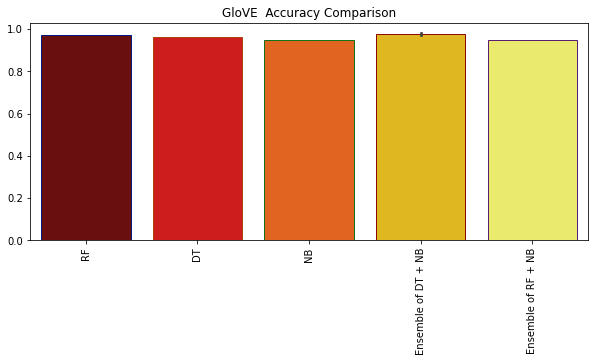

In [ ]:
 

plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('GloVE  Accuracy Comparison')
plt.show()

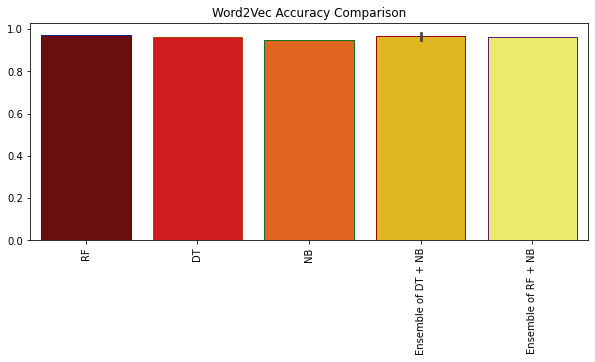

In [ ]:
 
plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Word2Vec Accuracy Comparison')
plt.show()

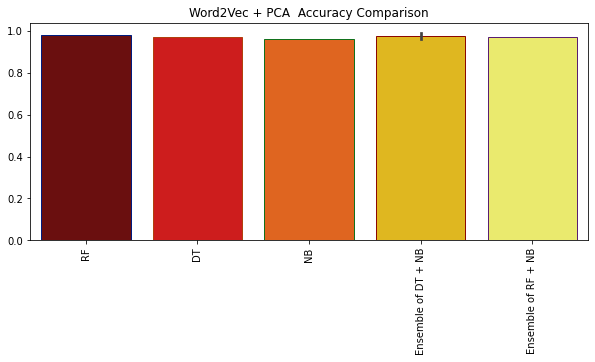

In [ ]:
MLA_names=['RF','DT','NB','Ensemble of DT + NB','Ensemble of RF + NB','Ensemble of DT + NB']
MLA_acc=[0.98,0.97,0.96,0.99,0.97,0.96 ]

plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('Word2Vec + PCA  Accuracy Comparison')
plt.show()

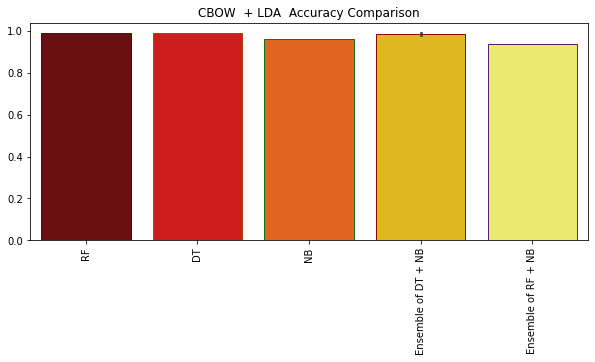

In [ ]:
 
plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('CBOW  + LDA  Accuracy Comparison')
plt.show()

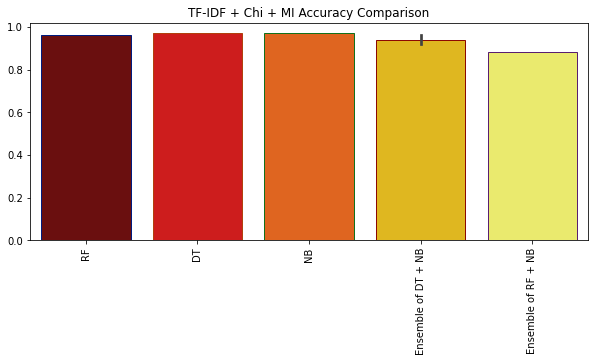

In [ ]:
 
plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('TF-IDF + Chi + MI Accuracy Comparison')
plt.show()

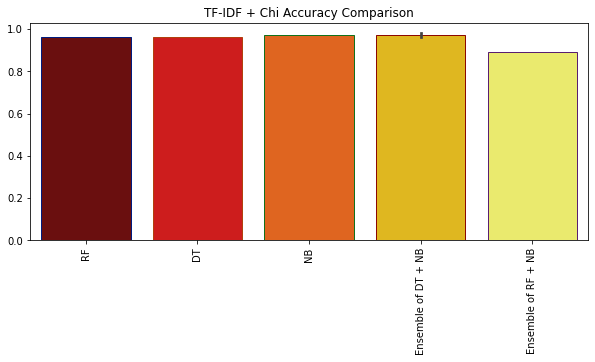

In [ ]:
 
plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('TF-IDF + Chi Accuracy Comparison')
plt.show()

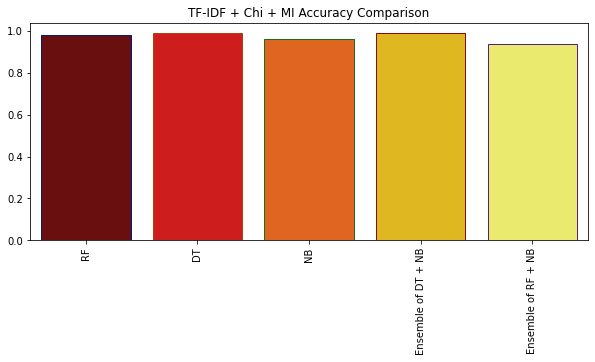

In [ ]:
 
plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('TF-IDF + Chi + MI Accuracy Comparison')
plt.show()

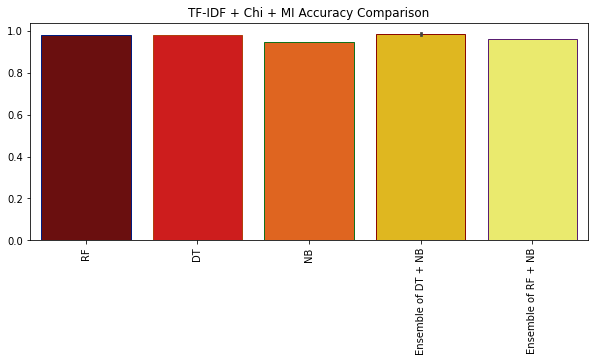

In [ ]:
 

plt.subplots(figsize=(10,4))
sns.barplot(x=MLA_names, y=MLA_acc,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('TF-IDF + Chi + MI Accuracy Comparison')
plt.show()